# Assignment 10 - NLP using Deep Learning

## Goals

In this assignment you will get to work with recurrent network architectures with application to language processing tasks and observe behaviour of the learning using tensorboard visualization.

You'll learn to use

 * word embeddings
 * LSTMs
 * performance monitoring via tensorboard + lightning
 * state-of-the-art cross-language transformers

While the notebook contains a lot of code, the actual **TODO**s for you are lightweight and easy to find. Use Google colab or the lab machines and provided environment to get started and finish quickly.

The goal of this exercise is to provide you with entry points to approach common NLP tasks with simple and elaborate methods.

### Deep learning environment in the lab

With the same kind of preparation as in [Assignment 6](../A6/A6.ipynb) we are going to use **[pytorch](http://pytorch.org)** for the deep learning aspects of the assignment.

There is a pytorch setup in the big data under the globally available anaconda installation.
However, it is recommended that you use the custom **gt** conda environment that contains all python package dependencies that are relevant for this assignment (and also tensorflow, etc.).

You could load it directly
```
source activate /usr/shared/CMPT/big-data/condaenv/gt
```
Once activated, you couls also add it as a user kernel to your jupyter installation
```
python -m ipykernel install --user --name="py-gt"
```
and then choose it as kernel when running this notebook.
To reproduce this environment on your own system, you could use `conda env export > environment.yml` and then use `mamba env update --prefix wherever_you_want_to_create_yours -f environment.yml` to make your own instance of this environment.

### Google colab VM setup

In [35]:
torch_version = !python -c "import torch; print(torch.__version__)"
if torch_version[0] < "2.0":
  !pip uninstall --yes fastai
  !pip install portalocker
  import re
  cudaver = !nvcc --version | grep release
  cudaver = re.search(r".*release (.*),.*", cudaver[0]).group(1)
  print(f"Found CUDA version {cudaver}")
  cudaver_nodot = cudaver.replace(".","")
  !pip install -U torch torchvision torchaudio "torchtext>=0.15" --index-url https://download.pytorch.org/whl/cu{cudaver_nodot}
  !pip install tensorboardX lightning

In [36]:
import torch
import torch.nn as nn
import numpy as np
import torchtext.functional as F

from IPython.display import Markdown
import pandas as pd

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
# location of "GoogleNews-vectors-negative300.bin.gz", only required if word2vec embedding is chosen
from pathlib import Path
bdenv_loc = Path('/usr/shared/CMPT/big-data')
bdata = bdenv_loc / 'data'

In [38]:
!nvidia-smi

Mon Apr  3 06:35:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    28W /  70W |   1071MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
torch.__version__, DEVICE

('2.0.0+cu118', device(type='cuda'))

# Task 1: Explore Word Embeddings

Word embeddings are mappings between words and multi-dimensional vectors, where the difference between two word vectors has some relationship with the meaning of the corresponding words, i.e. words that are similar in meaning are mapped closely together (ideally). This part of the assignment should enable you to

* Load a pretrained word embedding
* Perform basic operations, such as distance queries and evaluate simple analogies

In [40]:
# Load pre-trained GloVe model, trained on news articles

In [41]:
from torchtext.vocab import GloVe
glove_vectors = GloVe(name="6B")
EMBEDDING_DIM = glove_vectors.vectors.shape[1]

.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [01:01<00:00, 6496.07it/s]


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


glove model shape:  torch.Size([400000, 300])
embbed vector dimension:  300


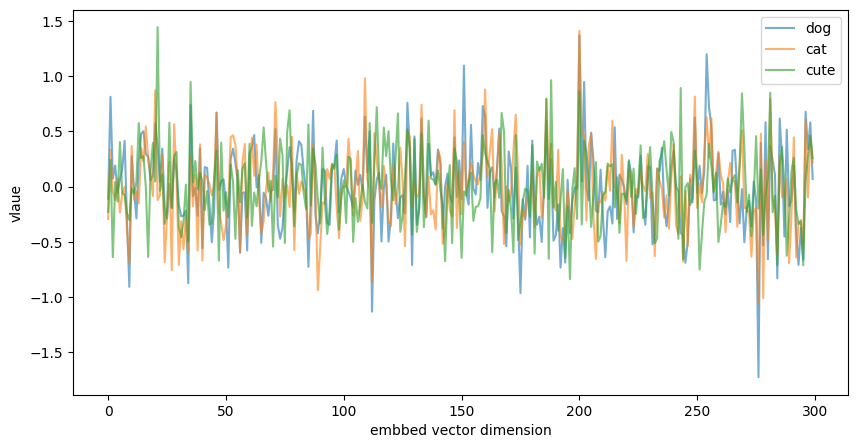

In [43]:
import matplotlib.pyplot as plt
import numpy as np
# read up about the vocab
# obtain vector representations for two or more words of your choice
print('glove model shape: ', glove_vectors.vectors.size())

words = ['dog', 'cat', 'cute']
embbed_vectors = glove_vectors.get_vecs_by_tokens(words, True)

print('embbed vector dimension: ', embbed_vectors.shape[1])

X = np.arange(300)
Y1, Y2, Y3 = embbed_vectors
plt.figure(figsize=(10,5))
plt.plot(X, Y1, alpha = 0.6, label = "dog")
plt.plot(X, Y2, alpha = 0.6, label = "cat")
plt.plot(X, Y3, alpha = 0.6, label = "cute")
plt.xlabel("embbed vector dimension")
plt.ylabel("vlaue")
plt.legend()
plt.show()
# to confirm that this worked, print out the number of elements of the vector
# and make a line plot that shows each vector as a line graph

In [44]:
# determine the 10 words that are closest in the embedding to the first word vector your produced above

TARGET_WORD = words[0]

# use cosine similarity to find the top k words
def knn(W, x, k):
    cos = torch.matmul(W, x.view((-1,))) / (
        (torch.sum(W * W, dim=1) + 1e-9).sqrt() * torch.sum(x * x).sqrt())
    _, topk = torch.topk(cos, k=k)
    topk = topk.cpu().numpy()
    return topk, [cos[i].item() for i in topk]


def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.vectors,
                    embed.vectors[embed.stoi[query_token]], k+1)
    for i, c in zip(topk[1:], cos[1:]):
        print('cosine sim=%.3f: %s' % (c, (embed.itos[i])))


get_similar_tokens(TARGET_WORD, 10, glove_vectors)
# are the nearest neighbours similar in meaning?
# try different seed words, until you find one whose neighbourhood looks OK

cosine sim=0.789: dogs
cosine sim=0.682: cat
cosine sim=0.629: pet
cosine sim=0.594: puppy
cosine sim=0.547: hound
cosine sim=0.537: horse
cosine sim=0.532: animal
cosine sim=0.508: cats
cosine sim=0.504: canine
cosine sim=0.502: pets


In [45]:
# using a combination of positive and negative words, find out which word is most
# similar to woman + king - man
def get_analogy(token1, token2, token3, embed):
  vecs = [embed.vectors[embed.stoi[t]] for t in [token1, token2, token3]]
  x = vecs[0] + vecs[1] - vecs[2]
  topk, cos = knn(embed.vectors, x, 4)
  #need to filter out the origin words
  tokens = {token1, token2, token3}
  for t in topk:
    if(embed.itos[t] not in tokens):
      return embed.itos[t]

get_analogy('woman', 'king', 'man', glove_vectors)

'queen'

In [46]:
# You may find that the results of most word analogy combinations don't work well sometimes, but not in all cases.
# However, explore a bit and find two more cases where the output of your word vector algebra makes sense.

print("man-woman : ", "son-[",get_analogy('woman', 'son', 'man', glove_vectors),"]")

# beijing-china : tokyo-japan
print("beijing-tokyo : ", "china-[",get_analogy('china', 'tokyo', 'beijing', glove_vectors),"]")

man-woman :  son-[ daughter ]
beijing-tokyo :  china-[ japan ]


# Task 2: Sequence modeling with RNNs or transformers

In this task you will get to use a learning and a rule-based model of text sentiment analysis. To keep things simple, you will receive almost all the code and are just left with the task to tune the given algorithms, see the part about instrumentation below.
Look for *TODO* to find places where your input is required.

## SST-2 Binary text classification with XLM-RoBERTa model and LSTMs

The XLM-RoBERTa related portions of this notebook are from [a tutorial](https://pytorch.org/text/main/tutorials/sst2_classification_non_distributed.html) authored by `Parmeet Bhatia <parmeetbhatia@fb.com>`

Adaptation of the modern torchtext pipeline to also allow switching to recurrent model with different pre-trained word embeddings by `Steven Bergner <sbergner@sfu.ca>`

The steps below demonstrate how to train a text classifier on SST-2 binary dataset using a pre-trained XLM-RoBERTa (XLM-R) model. Customizations to switch parts of the pipeline to different models are also enabled.

We will show how to use torchtext library to:

1. build text pre-processing pipeline for XLM-R model
2. read SST-2 dataset and transform it using text and label transformation
3. instantiate a classification model using pre-trained XLM-R encoder
4. change pipeline components to swap out any part of the data and model pipeline


## Data Transformation

Models like XLM-R cannot work directly with raw text. The first step in training
these models is to transform input text into tensor (numerical) form such that it
can then be processed by models to make predictions. A standard way to process text is:

1. Tokenize text
2. Convert tokens into (integer) IDs
3. Add any special tokens IDs

XLM-R uses sentencepiece model for text tokenization. Below, we use pre-trained sentence piece
model along with corresponding vocabulary to build text pre-processing pipeline using torchtext's transforms.
The transforms are pipelined using :py:func:`torchtext.transforms.Sequential` which is similar to :py:func:`torch.nn.Sequential`
but is torchscriptable. Note that the transforms support both batched and non-batched text inputs i.e, one
can either pass a single sentence or list of sentences.




Caution: If you want to learn more about torchtext, be careful to **not** read the docs at:
https://torchtext.readthedocs.io/en/latest/
They claim to be "latest", but are of version 0.4.0

Instead, find **current docs** here: https://pytorch.org/text/stable/index.html
or simply keep reading, as this tutorial shows how to use the recent version.

In [47]:
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader

padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 256
xlmr_vocab_path = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
xlmr_spm_model_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"

# transformation piplien
# use the sentencepice tokenizer
# turn the tokens into ids using vocab
# add two start and end token to the whole sequence
text_transform = T.Sequential(
    T.SentencePieceTokenizer(xlmr_spm_model_path),
    T.VocabTransform(load_state_dict_from_url(xlmr_vocab_path)),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

Alternately, we could also use transform shipped with pre-trained model that does all of the above out-of-the-box
```
  text_transform = XLMR_BASE_ENCODER.transform()
```

In [48]:
# obtain the vocabulary of the data pipeline, so that we can convert word <--> word_index
# allowing us to plug in different word embeddings

vocab = text_transform[1].vocab.vocab
word_to_idx = vocab.get_stoi()

## Model and training parameters

In addition to the transformer model, we also create an LSTM based model for text classification.

Change the parameters below to switch between models and make adjustments to the training.

In [49]:
import time

# TODO make adjustments here to achieve acceptable training performance with LSTMs
# Also, try out the Roberta model for comparison

# 1.Switch model between LSTM and Roberta.
# 2. Adjust the hyperparamenters like the word emdedding type and embedding dimensions.

EPOCHS = 8
USE_GPU = torch.cuda.is_available()
print(USE_GPU)
DROPOUT = .3
timestamp = str(int(time.time()))
best_dev_acc = 0.0

do_use_roberta_model = True
if do_use_roberta_model:
    LEARNING_RATE = 1e-5
    EPOCHS = 1
    BATCH_SIZE = 128
    EMBEDDING_TYPE = 'built-in'
else:
    #EMBEDDING_TYPE = 'word2vec'
    EMBEDDING_TYPE = 'glove'
    #EMBEDDING_TYPE = 'glovefull'
    EMBEDDING_DIM = 300
    HIDDEN_DIM = 50
    BATCH_SIZE = 128
    USE_BILSTM = True
    LEARNING_RATE = 1e-4
    do_freeze_embedding = False
    do_use_roberta_classifier = False # roberta_classifier only used when we use roberta model


True


In [50]:
def maybe_gpu(v):
    return v.cuda() if USE_GPU else v

In [51]:
from torch.autograd import Variable
import torch.nn.functional as nnF

# define the LSTM model using the above hyperparameters
class LSTMSentiment(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size,
                 use_gpu, batch_size, dropout=0.5, bidirectional=False, classifier_head=None):
        """Prepare individual layers"""
        super(LSTMSentiment, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_gpu = use_gpu
        self.batch_size = batch_size
        self.dropout = dropout
        self.num_directions = 2 if bidirectional else 1
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=bidirectional)
        self.hidden2label = nn.Linear(hidden_dim*self.num_directions, label_size)
        self.hidden = self.init_hidden()
        self.classifier_head = classifier_head

    def init_hidden(self, batch_size=None):
        """Choose appropriate size and type of hidden layer"""
        if not batch_size:
            batch_size = self.batch_size
        #what = torch.randn
        what = torch.zeros
        # first is the hidden h
        # second is the cell c
        return (maybe_gpu(Variable(what(self.num_directions, batch_size, self.hidden_dim))),
                maybe_gpu(Variable(what(self.num_directions, batch_size, self.hidden_dim))))

    def classify(self, features):
        y = self.hidden2label(features)
        log_probs = nnF.log_softmax(y, dim=1)
        return log_probs

    def forward(self, sentence):
        """Use the layers of this model to propagate input and return class log probabilities"""
        if self.use_gpu:
            sentence = sentence.cuda()
        x = self.embeddings(sentence).permute(1,0,2)
        batch_size = x.shape[1]
        self.hidden = self.init_hidden(batch_size=batch_size)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        features = lstm_out[-1]
        if self.classifier_head:
            #unsqueeze: introduce dummy second dimension, so that classifier_head can drop it
            return self.classifier_head(torch.unsqueeze(features, 1))
        else:
            return self.classify(features)

Choose and load a word embedding that provides the feature input to the RNN/LSTM.

In [52]:
# The Roberta/LSTM model needs word embedding before classification
# set the var `pretrained_embeddings` into the one we choose above

if 'glove' == EMBEDDING_TYPE:
    from torchtext.vocab import GloVe
    glove_vectors = GloVe(name="6B")
    EMBEDDING_DIM = glove_vectors.vectors.shape[1]
    use_embedding_directly = False
    if use_embedding_directly:
        pretrained_embeddings = maybe_gpu(glove_vectors.vectors)
    else:
        # prepare random embedding, then fill in glove vectors
        pretrained_embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), EMBEDDING_DIM)).astype('f')
        pretrained_embeddings[0] = 0
        for word, wi in glove_vectors.stoi.items():
            try:
                pretrained_embeddings[word_to_idx[word]-1] = glove_vectors.__getitem__(word)
            except KeyError:
                pass
        pretrained_embeddings = maybe_gpu(torch.from_numpy(pretrained_embeddings))
elif 'glovefull' == EMBEDDING_TYPE:
    from torchtext.vocab import GloVe
    glove_vectors = GloVe(cache="/usr/shared/CMPT/big-data/dot_torch_shared/.vector_cache/")
    # set freeze to false if you want them to be trainable
    pretrained_embeddings = maybe_gpu(glove_vectors.vectors)
    #my_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
elif 'word2vec' == EMBEDDING_TYPE:
    pretrained_embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), EMBEDDING_DIM)).astype('f')
    pretrained_embeddings[0] = 0
    try:
        word2vec
    except:
        print('Load word embeddings...')
        import gensim
        word2vec = gensim.models.KeyedVectors.load_word2vec_format(
                         bdata / 'GoogleNews-vectors-negative300.bin.gz', binary=True)
        EMBEDDING_DIM = 300
    for word, wi in word2vec.key_to_index.items():
        try:
            pretrained_embeddings[word_to_idx[word]-1] = word2vec.vectors[wi]
        except KeyError:
            pass
    # text_field.vocab.load_vectors(wv_type='', wv_dim=300)
    pretrained_embeddings = maybe_gpu(torch.from_numpy(pretrained_embeddings))
else:
    if not do_use_roberta_model:
        print('Unknown embedding type {}'.format(EMBEDDING_TYPE))

## Model preparation LSTM
Initialize the RNN model, if the above configuration is set to use it.

In [53]:
# we only use two classes of sentiment
num_classes = 2

# use the above hyperparameters and set the LSTM model
if not do_use_roberta_model:
    print('use LSTM')
    lstm_model = LSTMSentiment(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                                vocab_size=len(vocab), label_size=num_classes,\
                                use_gpu=USE_GPU, batch_size=BATCH_SIZE, dropout=DROPOUT, bidirectional=USE_BILSTM)
    lstm_model.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=do_freeze_embedding)
    model = lstm_model
else:
  print('use Roberta')

use Roberta


## Dataset
torchtext provides several standard NLP datasets. For complete list, refer to documentation
at https://pytorch.org/text/stable/datasets.html. These datasets are build using composable torchdata
datapipes and hence support standard flow-control and mapping/transformation using user defined functions
and transforms. Below, we demonstrate how to use text and label processing transforms to pre-process the
SST-2 dataset.





In [54]:
# load the dataset 
from torchtext.datasets import SST2
from torch.utils.data import DataLoader

batch_size = BATCH_SIZE

train_datapipe = SST2(split="train")
dev_datapipe = SST2(split="dev")

def ttf_first(x):
  #return (F.to_tensor(text_transform(x[0]), padding_value=padding_idx), x[1])
  return (text_transform(x[0]), x[1])

train_datapipe.map(lambda x: print(x[0]))

# Transform the raw dataset using non-batched API (i.e apply transformation line by line)
#train_datapipe = train_datapipe.map(ttf_first)
train_datapipe = train_datapipe.map(lambda x: (text_transform(x[0]), x[1]))
train_datapipe = train_datapipe.batch(batch_size)
train_datapipe = train_datapipe.set_length(len(list(train_datapipe)))
train_datapipe = train_datapipe.rows2columnar(["token_ids", "target"])
train_dataloader = DataLoader(train_datapipe, batch_size=None)

#dev_datapipe = dev_datapipe.map(ttf_first)
dev_datapipe = dev_datapipe.map(lambda x: (text_transform(x[0]), x[1]))
dev_datapipe = dev_datapipe.batch(batch_size)
dev_datapipe = dev_datapipe.set_length(len(list(dev_datapipe)))
dev_datapipe = dev_datapipe.rows2columnar(["token_ids", "target"])
dev_dataloader = DataLoader(dev_datapipe, batch_size=None)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


## Model preparation - RoBERTa

torchtext provides SOTA pre-trained models that can be used to fine-tune on downstream NLP tasks.
Below we use pre-trained XLM-R encoder with standard base architecture and attach a classifier head to fine-tune it
on SST-2 binary classification task. We shall use standard Classifier head from the library, but users can define
their own appropriate task head and attach it to the pre-trained encoder. For additional details on available pre-trained models,
please refer to documentation at https://pytorch.org/text/main/models.html





In [55]:
# this part is the preparation of the Roberta model
# Here the encoder and the classfication is seperated
num_classes = 2

from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

def make_roberta_classification_model(num_classes):
    roberta_input_dim = 768
    classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=roberta_input_dim)
    return XLMR_BASE_ENCODER.get_model(head=classifier_head)

if do_use_roberta_model:
    model = make_roberta_classification_model(num_classes)
else:
    model = lstm_model
    if do_use_roberta_classifier:
        feature_dim = model.hidden_dim + (USE_BILSTM * model.hidden_dim)
        classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=feature_dim)
        model.classifier_head = classifier_head

model.to(DEVICE) # This line has a bug, it has an extra semicolon!!!

RobertaModel(
  (encoder): RobertaEncoder(
    (transformer): TransformerEncoder(
      (token_embedding): Embedding(250002, 768, padding_idx=1)
      (layers): TransformerEncoder(
        (layers): ModuleList(
          (0-11): 12 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (linear1): Linear(in_features=768, out_features=3072, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=3072, out_features=768, bias=True)
            (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (positional_embedding): PositionalEmbedding(
        (embedding): Embedding(5

## Training methods

Let's now define the standard optimizer and training criteria as well as some helper functions
for training and evaluation. The methods below work for either choice of model.




In [56]:
# the following training method both use the above defined `model`, it could be either LSTM or XLM-R
# use the lightning api to control the whole training procedure
import lightning.pytorch as pl
from torch.optim import AdamW
from torchmetrics import Accuracy

# TODO adjust this cell for Task B1

class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.train() # train here 
        self.criteria = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(self.device)
        output = self.model(input)
        target = torch.tensor(batch["target"]).to(DEVICE)
        loss = self.criteria(output, F.to_tensor(batch["target"]).to(self.device))
        self.accuracy(output, target)
        self.log('loss', loss)
        self.log('train_acc_step', self.accuracy)
        return loss

    def validation_step(self, batch, batch_idx):
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(self.device)
        output = self.model(input)
        target = torch.tensor(batch["target"]).to(DEVICE)
        self.val_accuracy(output, target)
        self.log('val_acc_step', self.val_accuracy, batch_size=BATCH_SIZE)
    
    def on_train_epoch_end(self):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr=LEARNING_RATE)

In [57]:
import torchtext.functional as F
from torch.optim import AdamW

learning_rate = LEARNING_RATE
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()

def train_step(input, target):
    model.train()
    # check device
    # print('model device', next(model.parameters()).device)
    output = model(input)
    # print('output device', output.is_cuda)
    loss = criteria(output, target)
    optim.zero_grad()
    loss.backward()
    optim.step()


def eval_step(input, target):
    output = model(input)
    loss = criteria(output, target).item()
    return float(loss), (output.argmax(1) == target).type(torch.float).sum().item()


def evaluate():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for batch in dev_dataloader:
            input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(DEVICE)
            target = torch.tensor(batch["target"]).to(DEVICE)
            loss, predictions = eval_step(input, target)
            total_loss += loss
            correct_predictions += predictions
            total_predictions += len(target)
            counter += 1
    
    return total_loss / counter, correct_predictions / total_predictions


In [58]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
import datetime

tb_logdir = "logs-a10"

logger = TensorBoardLogger(tb_logdir, name="senti_model")
trainer = Trainer(logger=logger, max_epochs=10)
torch.cuda.empty_cache()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [59]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# !kill 47819
%tensorboard --logdir {tb_logdir}

In [61]:
# trainer.fit(LitModel(model), train_dataloader, dev_dataloader)

### The actual task (B1): Tensorboard instrumentation (TODO)

Tensorboard is a visualiation system for deep learning. The pytorch integration can now be done via [toch lightning](https://www.pytorchlightning.ai/index.html).

1. take a look at how tensorboard works for tensorflow profiling and visualization in [tensorboard](https://www.tensorflow.org/)
1. instead of instrumenting with tensorboard directly, adjust the LightningModel training to pass performance info to the `logger`
1. launch tensorboard and inspect the log folder, i.e. run `!tensorboard --logdir {tb_logdir}` from the folder of this notebook

## Train

Now we have all the ingredients to train our classification model. Note that we are able to directly iterate
on our dataset object without using DataLoader. Our pre-process dataset  shall yield batches of data already,
thanks to the batching datapipe we have applied. For distributed training, we would need to use DataLoader to
take care of data-sharding.




In [28]:
# TODO Use the tensorboard + lightning setup above to log the training loss and accuracy

# Below is the traning process without lighting + tensorboard 
# num_epochs = 1
# for e in range(num_epochs):
#     for batch in train_dataloader:
#         input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(DEVICE)
#         target = torch.tensor(batch["target"]).to(DEVICE)
#         print(input)
#         train_step(input, target)

#     loss, accuracy = evaluate()
#     print("Epoch = [{}], loss = [{}], accuracy = [{}]".format(e, loss, accuracy))

# Below is the training process using lighting + tensorboard
trainer.fit(LitModel(model), train_dataloader, dev_dataloader)

# Produce a screenshot of the experimental performance for different training rounds of your
# (BI-)LSTM model


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | model    | RobertaModel       | 278 M 
1 | criteria | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
278 M     Trainable params
0         Non-trainable params
278 M     Total params
1,112.178 Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | RobertaModel

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Task B2: Tune the model (TODO)

After connecting the output of your model train and test performance with tensorboard. Change the model and training parameters above to improve the model performance. We would like to see variable plots of how validation accuracy evolves over a number of epochs for at least two different parameter choices, you can stop exploring when you exceed a model accuracy of 76%.

Show a tensorboard screenshot with performance plots that combine at least 2 different tuning attempts. Store the screenshot as `tensorboard.png`. Then keep the best performing parameters set in this notebook for submission and evaluate the comparison below with your best model. 

# Tunning Result
1. Use LSTM with dropout rate to be 0.3, and max_epoch to be 10 =>0.91
2. Use XML-R with dropout rate to be 0.3, and max_epoch to be 10 =>0.94

In the `tensorboard.png` screenshot The yellow line represents LSTM, and the dark grey line represents XML-R.

## Comparison with Vader (NLTK)
Vader is a rule-based sentiment analysis algorithm that performs quite well against more complex architectures. The test below is to see, whether LSTMs are able to beat its performance.

In [29]:
# get text data from torchtext dataloader
vocab_itos = vocab.get_itos()
text_data = []
for ba in dev_dataloader:
    text = ("".join(
            ["".join(
                vocab_itos[tid]) for tokens in ba["token_ids"] 
                for tid in tokens ])
                .replace("▁"," ")
                .replace("<s>","")
                .split("</s>"))
    text_and_target = list(zip(text, ba["target"]))
    text_data.extend(text_and_target)

In [30]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

lab_vpred = np.zeros((len(text_data), 2))
for k, (sentence, label) in enumerate(text_data):
    ss = sid.polarity_scores(sentence)
    lab_vpred[k,:] = (int(ss['compound']>0), int(label))

vader_acc = 1-abs(lab_vpred[:,0]-lab_vpred[:,1]).mean()
print('vader acc: {}'.format(vader_acc))
logger.log_metrics({'Final/VaderAcc': vader_acc})

vader acc: 0.6594036697247707


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Perform the model tuning and training in the previous task 2.B2 until you outperform the Vader algorithm by at least 7% in accuracy using the LSTM model.

## Task 2.C Train and use the Roberta model

In [31]:
# some words from https://www.fluentu.com/blog/french/french-feelings/

lines = """This is fantastic!
 Not sure.
 Probably OK.
 Very well!
 Das ist gut!
Ich finde das bemerkenswert.
Klasse Vorstellung.
Lieber nicht anschauen.
heureux
heureuse
content
pas triste
absolument pas triste
énervé
pressé
fâché
en colère 
fatigué
s’ennuyer
occupé
navré
épuisé
malade
inquiet
inquiète
ravi
somos mejores amigos"""

# model.eval()

### Your task (TODO)

1. Train the Roberta model with the given setup above for 1 epoch
1. Ensure that your model test accuracy is > 75%
1. Save the model weights
1. Complete the SentimentPredictor class below to:
  1. Load the model from disk to create a new model on the CPU
  1. Use the restored model to compute Positive sentiment probabilities for each word in a list of words
1. Show a dataframe of the word list given above and positivity probabilities sorted in order of descending probability

In [32]:
# save the Roberta model trained in the last task
import os

path="/content/drive/MyDrive/assignment10"
os.chdir(path)
os.listdir(path)

MODEL_PATH ='./model.pth'

torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
import math
class SentimentPredictor:
  def __init__(self):
    self.model = make_roberta_classification_model(2)
    self.model.load_state_dict(torch.load(MODEL_PATH))
    self.model.eval()

  def __call__(self, text, prob=True):
    if isinstance(text, str):
      text = [text]
      unpack = True
    else:
      unpack = False
    # tokenize
    tokens = []
    for t in text:
      tokens.append(text_transform(t))
    # set input
    input = F.to_tensor(tokens, padding_value=padding_idx)
    output = self.model(input)
    probs = []
    for o in output:
      o1, o2 = o
      o1 = math.exp(o1)
      o2 = math.exp(o2)
      p1 = o1/(o1+o2)
      p2 = o2/(o1+o2)
      probs.append([p1,p2])
    probs = np.array(probs)
    logit = probs
    if prob:
      if unpack:
        return probs[0,1].tolist()
      else:
        return probs[:,1].tolist()
    else:
      return bool(logit.argmax())

sp = SentimentPredictor()

In [34]:
# TODO use sp(lines.split("\n")) for the above task
import pandas as pd

pos_prob = sp(lines.split("\n"))
column_values = ['positive_prob']
df = pd.DataFrame(data = pos_prob, columns = column_values)
df['sentense'] = np.array(lines.split("\n"))
df.sort_values(by=['positive_prob'],ascending=False)

,positive_prob,sentense
3,0.999913,Very well!
0,0.999909,This is fantastic!
6,0.999881,Klasse Vorstellung.
4,0.999871,Das ist gut!
8,0.999693,heureux
9,0.999522,heureuse
2,0.999468,Probably OK.
5,0.999359,Ich finde das bemerkenswert.
10,0.999339,content
25,0.989136,ravi


Note, that the model was trained for a task in English, simply based on .tsv files with phrases and a class label.

In the example above, we are using this same model to perform the trained task in other languages. Please add some words from other languages you may know. Do the model predictions make sense?

I add a Spanish sentence means "you are my best friend" and it seems that the result is reasonable.

## Submission

Save [this notebook](A10.ipynb) containing all cell output and upload your submission as one `A10.ipynb` file.
Also, include the screenshot of your tensorboard debugging session as `tensorboard.png`.